# Example of an experiment

Create all the pieces and run a toy experiment.

For testing and design.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src import Dataset, Preprocessor, ClusteringMethod, Experiment, evaluate

## First create a dataset

Dataset class should read in the data and expose the waveforms and labels as attributes.

This is very simple right now, just a container to hold datasets with a common interface.

Could use pytorch or pytorch-like dataset interface in the future

In [15]:
class Siracusano2019Lite(Dataset):
    """Subsample of Siracusano waveforms for testing"""

    def __init__(self, path):
        self.path = path

        df = pd.read_pickle(self.path)[::55]

        self.waveforms = np.stack(df["waveform"].values)
        self.labels = df["label"].values - 1 #convert from Matlab indexing
        self.attrs = {
            "fs":5e6, # sampling frequency
        }

class Siracusano2019(Dataset):

    def __init__(self, path):
        self.path = path

        df = pd.read_pickle(self.path)

        self.waveforms = np.stack(df["waveform"].values)
        self.labels = df["label"].values - 1 #convert from Matlab indexing
        self.attrs = {
            "fs":5e6,
        }

In [16]:
siracusano = Siracusano2019("/Users/nate/datasets/siracusano2019AE/siracusano.pkl")

In [17]:
siracusano.attrs["fs"]

5000000.0

In [18]:
siracusano.waveforms.shape, siracusano.labels.shape

((16650, 1000), (16650,))

## Next, create the steps needed for preprocessing and clustering the data

Can create any number of preprocessing steps, for example filtering, spectrogram creation, etc.

Then create a clustering method.

This example simply creates spectrograms from the waveforms, then clusters using kmeans directly on the spectrograms using Euclidean distance.

In [19]:
from scipy.signal import spectrogram

class SpectrogramPreprocessor(Preprocessor):

    def __init__(
        self,
        fs,
        nperseg=None,
        noverlap=None,
        nfft=None,
        scaling='density',
        mode='psd',
        name="spectrogram"
    ):
        self.parameters = {
            "fs":fs,
            "nperseg":nperseg,
            "noverlap":noverlap,
            "nfft":nfft,
            "scaling":scaling,
            "mode":mode,
            "name":name
        }

    def transform(self, X, y=None):
        _, _, sxx = spectrogram(
                        X,
                        fs=self.parameters["fs"],
                        nperseg=self.parameters["nperseg"],
                        noverlap=self.parameters["noverlap"],
                        nfft=self.parameters["nfft"],
                        scaling=self.parameters["scaling"],
                        mode=self.parameters["mode"]
                    )
        return sxx

In [20]:
from sklearn.cluster import KMeans

class KmeansSpectrogramClusterer(ClusteringMethod):

    def __init__(self, k, name="kmeans"):

        self.parameters = {"name":"kmeans", "k":k}
        self.kmeans = KMeans(k)

    def fit(self, X, y=None):
        if len(X.shape) >= 2:
            X = X.reshape(X.shape[0], -1)
        self.kmeans.fit(X)
        return self

    def predict(self, X, y=None):
        if len(X.shape) >= 2:
            X = X.reshape(X.shape[0], -1)
        return self.kmeans.predict(X)

    def transform(self, X, y=None):
        if len(X.shape) >= 2:
            X = X.reshape(X.shape[0], -1)
        return X

## Now, combine into an experiment and run

In [21]:
preprocess_spectrogram = SpectrogramPreprocessor(
                            fs=siracusano.attrs["fs"],
                            nperseg=32,
                            noverlap=16,
                            nfft=512,
                        )
cluster_kmeans = KmeansSpectrogramClusterer(3)

siracusano_spectrogram_kmeans = Experiment(
                                    siracusano,
                                    [preprocess_spectrogram],
                                    cluster_kmeans
                                )

In [22]:
siracusano_spectrogram_kmeans.fit()
_ = siracusano_spectrogram_kmeans.predict()

In [23]:
siracusano_spectrogram_kmeans.evaluate()

,Results
ari,0.205167
nmi,0.207388
acc,0.197117
homogeneity,0.200653
completeness,0.214591
v,0.207388


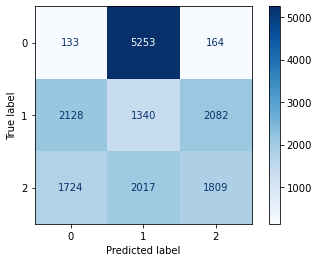

In [24]:
cm = siracusano_spectrogram_kmeans.plot_confusion(cmap="Blues")

/Users/nate/mambaforge/envs/unsupervised_baseline/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nate/mambaforge/envs/unsupervised_baseline/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


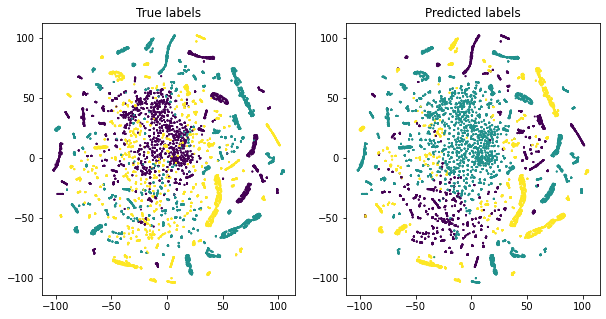

In [25]:
tsne = siracusano_spectrogram_kmeans.plot_tsne()

In [14]:
siracusano_spectrogram_kmeans.__repr__()

'<src.experiment.Experiment object at 0x13d366280>'